# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import itertools
import pandas as pd
from tabulate import tabulate

# Funções

In [ ]:
# ------------- Funções de plot -----------
def plot_funcoes_geral(funcoes, nomes, universo, ponto=None, ax=None):
    cores = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'brown']
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    linhas, labels = [], []
    xs = np.linspace(universo[0], universo[1], 300)
    for i, (nome, func) in enumerate(zip(nomes, funcoes)):
        ys = [func(x) for x in xs]
        linha, = ax.plot(xs, ys, label=nome, color=cores[i % len(cores)])
        ax.fill_between(xs, ys, alpha=0.1, color=cores[i % len(cores)])
        linhas.append(linha)
        labels.append(nome)

        if ponto is not None:
            grau = func(ponto)
            ax.scatter(ponto, grau, color=cores[i % len(cores)])
            ax.axvline(ponto, color='gray', linestyle='--')
            ponto_plot, = ax.plot([], [], marker='o', linestyle='', color=cores[i % len(cores)],
                                  label=f'{nome} ({ponto:.2f} → {grau:.2f})')
            linhas.append(ponto_plot)
            labels.append(f'{nome} ({ponto:.2f} → {grau:.2f})')

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('Universo')
    ax.set_ylabel('Grau de Pertinência')
    ax.grid(True)

    ax.legend(linhas, labels, loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., fontsize='small')

def plot_conjunto_agregado(y, agregado, defuzz, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(y, agregado, label='Conjunto Agregado', color='gray')
    ax.fill_between(y, agregado, alpha=0.3, color='gray')
    ax.axvline(defuzz, color='red', linestyle='--', label=f'Defuzz = {defuzz:.2f}')
    ax.set_title('Resultado Agregado + Defuzzificação')
    ax.set_xlabel('Intensidade de Ventilação')
    ax.set_ylabel('Grau de Pertinência')
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)

    # LEGEND OUTSIDE
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., fontsize='small')

# ------------- Funções Pertinência -----------

def triangular(x, a, b, c):
  if x <= a:
    return 0
  elif a < x <= b:
     return (x - a) / (b - a)
  elif b < x <= c:
     return (c - x) / (c - b)
  elif x > c:
     return 0
  else:
     return 0

def s_shaped(x, a, b):
  if x < a:
    return 0
  elif a <= x <= ((a+b)/2):
    return 2*(((x - a) / (b - a))**2)
  elif ((a+b)/2) < x <= b:
    return 1 - 2*(((b - x) / (b - a))**2)
  elif x > b:
    return 1
  else:
    return 0

def z_shaped(x, a, b):
  if x < a:
    return 1
  elif a <= x <= ((a+b)/2):
    return 1 - 2*(((x - a) / (b - a))**2)
  elif ((a+b)/2) <= x <= b:
    return 2*(((b - x) / (b - a))**2)
  elif x > b:
    return 0
  else:
    return 0

def gaussiana(x, c, sigma):
    return (math.exp(((-(x-c)**2)) / (2 * sigma**2)))

def calcular_grau(x, func):
    if callable(func):
        return func(x)

    if isinstance(func, dict):
        tipo = func.get("tipo")
        params = func.get("parametros")

        if tipo == "triangular":
            a, b, c = params
            return triangular(x, a, b, c)
        elif tipo == "s":
            a, b = params
            return s_shaped(x, a, b)
        elif tipo == "z":
            a, b = params
            return z_shaped(x, a, b)
        elif tipo == "gaussiana":
            media, sigma = params
            return gaussiana(x, media, sigma)

        else:
            raise ValueError(f"Tipo de função de pertinência desconhecido: {tipo}")

    raise ValueError("Formato inválido para função de pertinência.")

# ------------Função para gerar as regras -----------
def gerar_regras_completas(a, b, c, saida):
    regras = []
    id_regra = 1

    for temp in a:
        for umid in b:
            for pessoas in c:
                # Conversão para índice para definir a "intensidade"
                idx_temp = a.index(temp)
                idx_umid = b.index(umid)
                idx_pess = c.index(pessoas)

                score = idx_temp + idx_umid + idx_pess

                # Definir saída baseada no score
                if score <= 3:
                    saida = 'Fraca'
                elif score <= 6:
                    saida = 'Moderada'
                elif score <= 8:
                    saida = 'Forte'
                else:
                    saida = 'Muito_forte'

                regras.append((id_regra, temp, umid, pessoas, saida))
                id_regra += 1

    return regras


def printar_tabela_regras(regras):
    df = pd.DataFrame(regras, columns=['ID', 'Temperatura', 'Umidade', 'Pessoas', 'Saída'])
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

def printar_regras_ativadas(regras_ativadas):
    colunas = ['ID', 'Temperatura', 'Umidade', 'Pessoas', 'Saída', 'Grau de Ativação']

    # Filtra regras com grau de ativação >= 0.01
    regras_filtradas = [regra for regra in regras_ativadas if regra[-1] >= 0.01]

    print(tabulate(regras_filtradas, headers=colunas, tablefmt='fancy_grid', floatfmt=".3f"))


# ------------Funções de defuzzificação -----------

# -------- Bissetriz ----
def defuzz_bisector(y, saida_agregada):
    area_total = np.sum(saida_agregada)
    if area_total == 0:
        return 0
    area_acumulada = np.cumsum(saida_agregada)
    metade_area = area_total / 2
    idx = np.where(area_acumulada >= metade_area)[0][0]
    return y[idx]

# -------- Média dos Máximos (MOM) ----
def defuzz_mom(y, saida_agregada):
    max_val = np.max(saida_agregada)
    if max_val == 0:
        return 0
    indices_maximos = np.where(saida_agregada == max_val)[0]
    return np.mean(y[indices_maximos])

# -------- Centróide ----
def defuzz_centroid(y, saida_agregada):
    soma_area = np.sum(saida_agregada)
    if soma_area == 0:
        return 0
    return np.sum(y * saida_agregada) / soma_area



# ------------Função para escolha de operador -----------
def operador_logico(g1, g2, g3, tipo='AND'):
    if tipo == 'AND':
        return min(g1, g2, g3)
    elif tipo == 'OR':
        return max(g1, g2, g3)
    else:
        raise ValueError("Operador lógico inválido: use 'AND', 'OR'")

# ------------Função de agregação de saída -----------
def agregar_saida(valor_atual, novo_valor, metodo='max'):
    if metodo == 'max':
        return max(valor_atual, novo_valor)
    elif metodo == 'sum':
        return min(1.0, valor_atual + novo_valor)
    elif metodo == 'mean':
        return (valor_atual + novo_valor) / 2
    elif metodo == 'prod':
        return valor_atual * novo_valor
    else:
        raise ValueError("Método de agregação inválido.")

# Mamdani

## Regras

In [ ]:
# Entrada 1: Temperatura Interna
temp_interna = np.linspace(-5, 40, 501)
entrada_x1_nomes = ['Negativa', 'Baixa', 'Moderada', 'Alta']
entrada_x1 = [lambda x: z_shaped(x, -5, 5),
                lambda x: gaussiana(x, 10, 5),
                lambda x: gaussiana(x, 25, 5),
                lambda x: s_shaped(x, 30, 40)]


# Entrada 2: Umidade Relativa
umidade_relativa = np.linspace(0, 100, 501)
entrada_x2_nomes = ['Perigosamente_baixa', 'Baixa', 'Média', 'Alta', 'Perigosamente_alta']
entrada_x2 = [
    lambda x: z_shaped(x, 0, 20),
    lambda x: triangular(x, 15, 30, 50),
    lambda x: triangular(x, 35, 50, 70),
    lambda x: triangular(x, 50, 70, 85),
    lambda x: s_shaped(x, 80, 100)
]

# Entrada 3: Número de Pessoas no Ambiente
pessoas = np.linspace(0, 1000, 501)
entrada_x3_nomes = ['Baixa_concentração', 'Media_concentração', 'Alta_concentração']
entrada_x3 = [
    lambda x: z_shaped(x, 0, 350),
    lambda x: triangular(x, 200, 500, 800),
    lambda x: s_shaped(x, 650, 1000)
]


# Saída: Intensidade da ventilação
y = np.linspace(0, 100, 501)
saida_agregada = np.zeros_like(y)
saída_y = ['Fraca', 'Moderada', 'Forte', 'Muito_forte']

funcoes_de_saida = [
    lambda x: triangular(x,  -10,  0,  25),     # Fraca
    lambda x: triangular(x, 15,  25,  55),      # Moderada
    lambda x: triangular(x, 45,  75 , 85),      # Forte
    lambda x: triangular(x, 75,  100, 110),     # Muito_forte
]


regras = gerar_regras_completas(entrada_x1_nomes, entrada_x2_nomes, entrada_x3_nomes, saída_y)

print("Conjunto Total de Regras:")
printar_tabela_regras(regras)
print("\n")

Conjunto Total de Regras:
╒══════╤═══════════════╤═════════════════════╤════════════════════╤═════════════╕
│   ID │ Temperatura   │ Umidade             │ Pessoas            │ Saída       │
╞══════╪═══════════════╪═════════════════════╪════════════════════╪═════════════╡
│    1 │ Negativa      │ Perigosamente_baixa │ Baixa_concentração │ Fraca       │
├──────┼───────────────┼─────────────────────┼────────────────────┼─────────────┤
│    2 │ Negativa      │ Perigosamente_baixa │ Media_concentração │ Fraca       │
├──────┼───────────────┼─────────────────────┼────────────────────┼─────────────┤
│    3 │ Negativa      │ Perigosamente_baixa │ Alta_concentração  │ Fraca       │
├──────┼───────────────┼─────────────────────┼────────────────────┼─────────────┤
│    4 │ Negativa      │ Baixa               │ Baixa_concentração │ Fraca       │
├──────┼───────────────┼─────────────────────┼────────────────────┼─────────────┤
│    5 │ Negativa      │ Baixa               │ Media_concentração │ Frac

## Teste 1

In [ ]:
# -----------Variaveis de Entrada---------- #
tp_interna_x1 = 25
ur_x2 = 56
n_pessoas_x3 = 990



# --- Fuzzificação -------------------------#

graus_temp    = {nome: calcular_grau(tp_interna_x1, params)
                 for nome, params in zip(entrada_x1_nomes, entrada_x1)}

graus_umidade = {nome: calcular_grau(ur_x2, params)
                 for nome, params in zip(entrada_x2_nomes, entrada_x2)}

graus_pessoas = {nome: calcular_grau(n_pessoas_x3, params)
                 for nome, params in zip(entrada_x3_nomes, entrada_x3)}


# --- Inferência Mamdani --------------------
inferencia = {}
regras_ativadas = []

for id_regra, nome_temp, nome_umidade, nome_pessoas, saida in regras:

    grau_temp = graus_temp.get(nome_temp, 0)
    grau_umid = graus_umidade.get(nome_umidade, 0)
    grau_pessoas = graus_pessoas.get(nome_pessoas, 0)

    grau_inferencia = operador_logico(grau_temp, grau_umid, grau_pessoas, tipo='AND')  # AND, OR

    if grau_inferencia > 0:
       regras_ativadas.append((id_regra, nome_temp, nome_umidade, nome_pessoas, saida, grau_inferencia))

    inferencia[saida] = agregar_saida(inferencia.get(saida, 0), grau_inferencia, metodo='max')  # max, sum, mean, prod #


# --- Conjunção Mamdani --------------------]
for func_saida, label in zip(funcoes_de_saida, saída_y):
    grau = inferencia.get(label, 0)
    if grau > 0:
        # func_saida já é um lambda que mapeia x → pertinência
        corte = np.array([min(grau, func_saida(yi)) for yi in y])
        saida_agregada = np.maximum(saida_agregada, corte)


print("\nRegras Ativadas:")
if regras_ativadas:
    printar_regras_ativadas(regras_ativadas)
else:
    print("Nenhuma regra foi ativada.")

print("\n")

# Cálculo dos métodos de defuzzificação
centroide = defuzz_centroid(y, saida_agregada)
bissetriz = defuzz_bisector(y, saida_agregada)
mom       = defuzz_mom(y, saida_agregada)

print(f'Defuzzificações: \n')
print(f'Centroide: {centroide:.2f}')
print(f'Bissetriz: {bissetriz:.2f}')
print(f'Média dos Máximos (MOM): {mom:.2f}')
print("\n")


Regras Ativadas:
╒══════╤═══════════════╤═══════════╤═══════════════════╤══════════╤════════════════════╕
│   ID │ Temperatura   │ Umidade   │ Pessoas           │ Saída    │   Grau de Ativação │
╞══════╪═══════════════╪═══════════╪═══════════════════╪══════════╪════════════════════╡
│   24 │ Baixa         │ Média     │ Alta_concentração │ Moderada │              0.011 │
├──────┼───────────────┼───────────┼───────────────────┼──────────┼────────────────────┤
│   27 │ Baixa         │ Alta      │ Alta_concentração │ Moderada │              0.011 │
├──────┼───────────────┼───────────┼───────────────────┼──────────┼────────────────────┤
│   39 │ Moderada      │ Média     │ Alta_concentração │ Moderada │              0.700 │
├──────┼───────────────┼───────────┼───────────────────┼──────────┼────────────────────┤
│   42 │ Moderada      │ Alta      │ Alta_concentração │ Forte    │              0.300 │
╘══════╧═══════════════╧═══════════╧═══════════════════╧══════════╧════════════════════╛


D

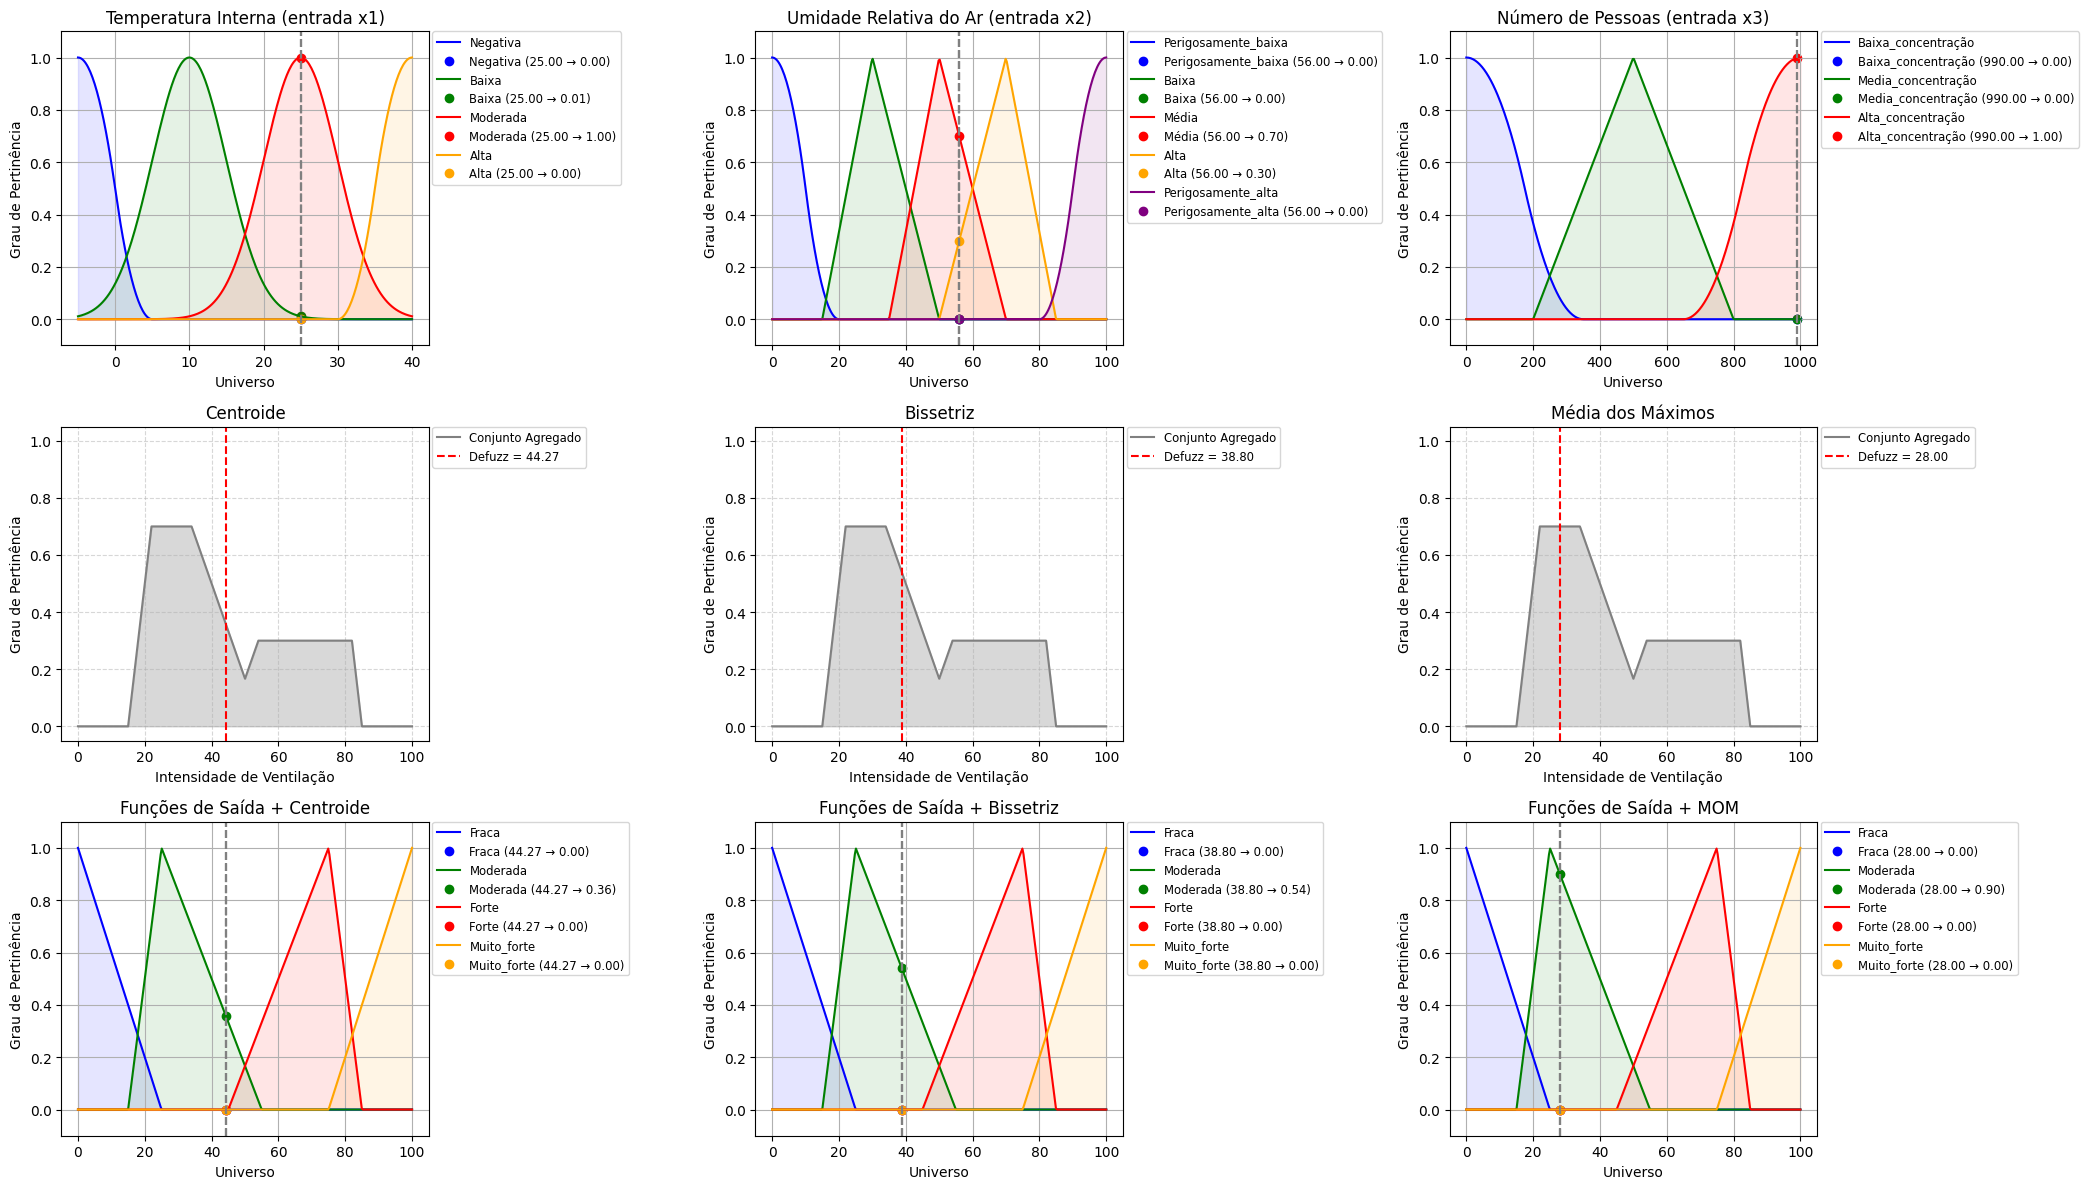

In [ ]:
# --- Plots --- (corrigido)
fig, axs = plt.subplots(3, 3, figsize=(21, 12))

# Entradas
plot_funcoes_geral(entrada_x1, entrada_x1_nomes, universo=(-5, 40), ponto=tp_interna_x1, ax=axs[0, 0])
axs[0, 0].set_title('Temperatura Interna (entrada x1)')

plot_funcoes_geral(entrada_x2, entrada_x2_nomes, universo=(0, 100), ponto=ur_x2, ax=axs[0, 1])
axs[0, 1].set_title('Umidade Relativa do Ar (entrada x2)')

plot_funcoes_geral(entrada_x3, entrada_x3_nomes, universo=(0, 1000), ponto=n_pessoas_x3, ax=axs[0, 2])
axs[0, 2].set_title('Número de Pessoas (entrada x3)')

# Conjunto Agregado + Defuzzificação
plot_conjunto_agregado(y, saida_agregada, centroide, ax=axs[1, 0])
axs[1, 0].set_title('Centroide')

plot_conjunto_agregado(y, saida_agregada, bissetriz, ax=axs[1, 1])
axs[1, 1].set_title('Bissetriz')

plot_conjunto_agregado(y, saida_agregada, mom, ax=axs[1, 2])
axs[1, 2].set_title('Média dos Máximos')

# Funções de saída com ponto marcado
plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=centroide, ax=axs[2, 0])
axs[2, 0].set_title('Funções de Saída + Centroide')

plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=bissetriz, ax=axs[2, 1])
axs[2, 1].set_title('Funções de Saída + Bissetriz')

plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=mom, ax=axs[2, 2])
axs[2, 2].set_title('Funções de Saída + MOM')

plt.tight_layout()
plt.show()

## Teste 2

In [ ]:


# -----------Variaveis de Entrada---------- #
tp_interna_x1 = 10
ur_x2 = 70
n_pessoas_x3 = 250



# --- Fuzzificação -------------------------#

graus_temp    = {nome: calcular_grau(tp_interna_x1, params)
                 for nome, params in zip(entrada_x1_nomes, entrada_x1)}

graus_umidade = {nome: calcular_grau(ur_x2, params)
                 for nome, params in zip(entrada_x2_nomes, entrada_x2)}

graus_pessoas = {nome: calcular_grau(n_pessoas_x3, params)
                 for nome, params in zip(entrada_x3_nomes, entrada_x3)}


# --- Inferência Mamdani --------------------
inferencia = {}
regras_ativadas = []

for id_regra, nome_temp, nome_umidade, nome_pessoas, saida in regras:

    grau_temp = graus_temp.get(nome_temp, 0)
    grau_umid = graus_umidade.get(nome_umidade, 0)
    grau_pessoas = graus_pessoas.get(nome_pessoas, 0)

    grau_inferencia = operador_logico(grau_temp, grau_umid, grau_pessoas, tipo='AND')  # AND, OR

    if grau_inferencia > 0:
       regras_ativadas.append((id_regra, nome_temp, nome_umidade, nome_pessoas, saida, grau_inferencia))

    inferencia[saida] = agregar_saida(inferencia.get(saida, 0), grau_inferencia, metodo='max')  # max, sum, mean, prod #


# --- Conjunção Mamdani --------------------]
for func_saida, label in zip(funcoes_de_saida, saída_y):
    grau = inferencia.get(label, 0)
    if grau > 0:
        # func_saida já é um lambda que mapeia x → pertinência
        corte = np.array([min(grau, func_saida(yi)) for yi in y])
        saida_agregada = np.maximum(saida_agregada, corte)


print("\nRegras Ativadas:")
if regras_ativadas:
    printar_regras_ativadas(regras_ativadas)
else:
    print("Nenhuma regra foi ativada.")

print("\n")

# Cálculo dos métodos de defuzzificação
centroide = defuzz_centroid(y, saida_agregada)
bissetriz = defuzz_bisector(y, saida_agregada)
mom       = defuzz_mom(y, saida_agregada)

print(f'Defuzzificações: \n')
print(f'Centroide: {centroide:.2f}')
print(f'Bissetriz: {bissetriz:.2f}')
print(f'Média dos Máximos (MOM): {mom:.2f}')
print("\n")


Regras Ativadas:
╒══════╤═══════════════╤═══════════╤════════════════════╤══════════╤════════════════════╕
│   ID │ Temperatura   │ Umidade   │ Pessoas            │ Saída    │   Grau de Ativação │
╞══════╪═══════════════╪═══════════╪════════════════════╪══════════╪════════════════════╡
│   25 │ Baixa         │ Alta      │ Baixa_concentração │ Moderada │              0.163 │
├──────┼───────────────┼───────────┼────────────────────┼──────────┼────────────────────┤
│   26 │ Baixa         │ Alta      │ Media_concentração │ Moderada │              0.167 │
├──────┼───────────────┼───────────┼────────────────────┼──────────┼────────────────────┤
│   40 │ Moderada      │ Alta      │ Baixa_concentração │ Moderada │              0.011 │
├──────┼───────────────┼───────────┼────────────────────┼──────────┼────────────────────┤
│   41 │ Moderada      │ Alta      │ Media_concentração │ Moderada │              0.011 │
╘══════╧═══════════════╧═══════════╧════════════════════╧══════════╧══════════════

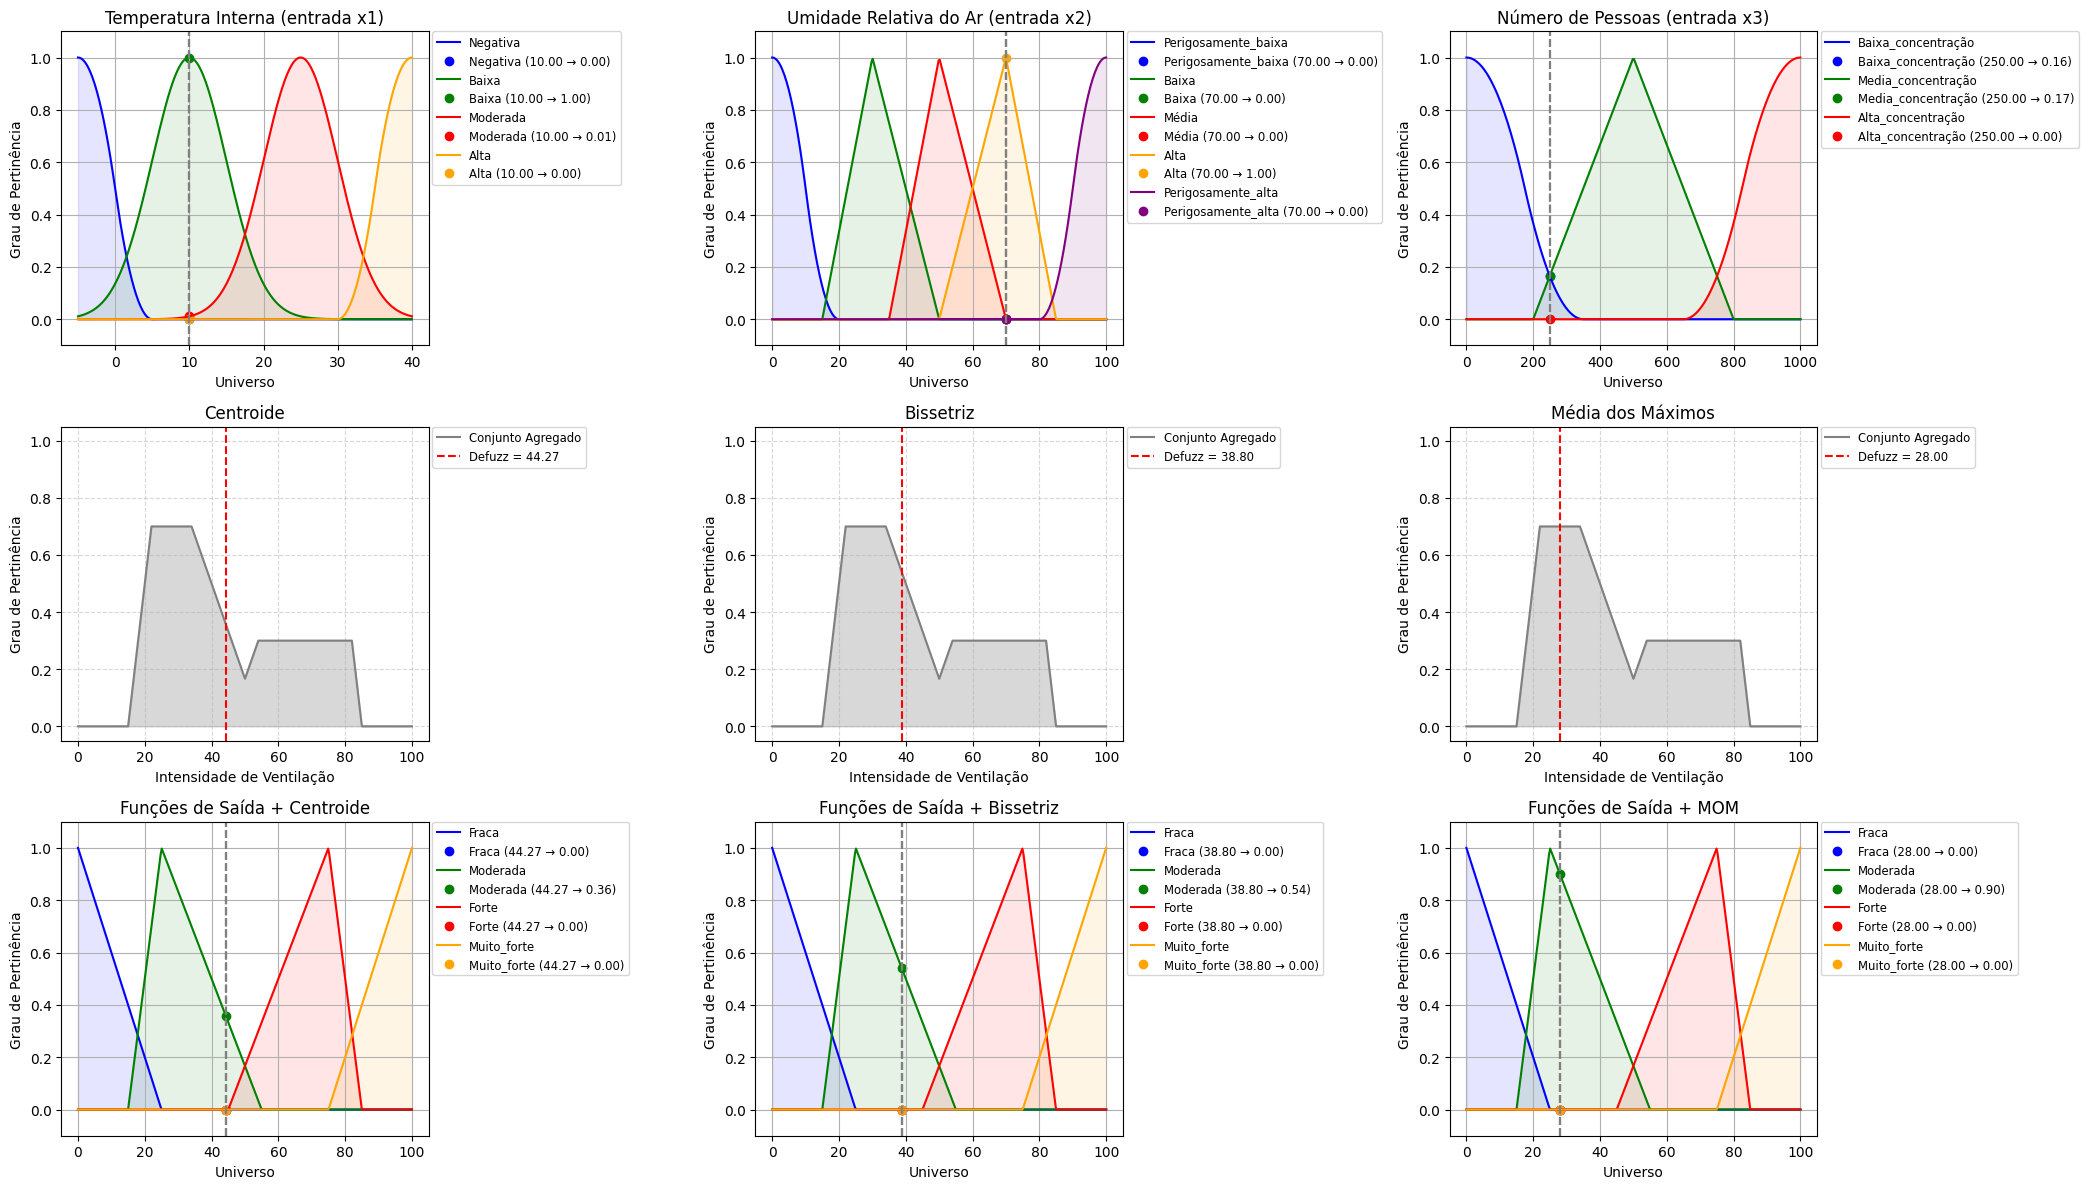

In [ ]:
# --- Plots --- (corrigido)
fig, axs = plt.subplots(3, 3, figsize=(21, 12))

# Entradas
plot_funcoes_geral(entrada_x1, entrada_x1_nomes, universo=(-5, 40), ponto=tp_interna_x1, ax=axs[0, 0])
axs[0, 0].set_title('Temperatura Interna (entrada x1)')

plot_funcoes_geral(entrada_x2, entrada_x2_nomes, universo=(0, 100), ponto=ur_x2, ax=axs[0, 1])
axs[0, 1].set_title('Umidade Relativa do Ar (entrada x2)')

plot_funcoes_geral(entrada_x3, entrada_x3_nomes, universo=(0, 1000), ponto=n_pessoas_x3, ax=axs[0, 2])
axs[0, 2].set_title('Número de Pessoas (entrada x3)')

# Conjunto Agregado + Defuzzificação
plot_conjunto_agregado(y, saida_agregada, centroide, ax=axs[1, 0])
axs[1, 0].set_title('Centroide')

plot_conjunto_agregado(y, saida_agregada, bissetriz, ax=axs[1, 1])
axs[1, 1].set_title('Bissetriz')

plot_conjunto_agregado(y, saida_agregada, mom, ax=axs[1, 2])
axs[1, 2].set_title('Média dos Máximos')

# Funções de saída com ponto marcado
plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=centroide, ax=axs[2, 0])
axs[2, 0].set_title('Funções de Saída + Centroide')

plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=bissetriz, ax=axs[2, 1])
axs[2, 1].set_title('Funções de Saída + Bissetriz')

plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=mom, ax=axs[2, 2])
axs[2, 2].set_title('Funções de Saída + MOM')

plt.tight_layout()
plt.show()

## Teste 3

In [ ]:


# -----------Variaveis de Entrada---------- #
tp_interna_x1 = 35
ur_x2 = 15
n_pessoas_x3 = 700



# --- Fuzzificação -------------------------#

graus_temp    = {nome: calcular_grau(tp_interna_x1, params)
                 for nome, params in zip(entrada_x1_nomes, entrada_x1)}

graus_umidade = {nome: calcular_grau(ur_x2, params)
                 for nome, params in zip(entrada_x2_nomes, entrada_x2)}

graus_pessoas = {nome: calcular_grau(n_pessoas_x3, params)
                 for nome, params in zip(entrada_x3_nomes, entrada_x3)}


# --- Inferência Mamdani --------------------
inferencia = {}
regras_ativadas = []

for id_regra, nome_temp, nome_umidade, nome_pessoas, saida in regras:

    grau_temp = graus_temp.get(nome_temp, 0)
    grau_umid = graus_umidade.get(nome_umidade, 0)
    grau_pessoas = graus_pessoas.get(nome_pessoas, 0)

    grau_inferencia = operador_logico(grau_temp, grau_umid, grau_pessoas, tipo='AND')  # AND, OR

    if grau_inferencia > 0:
       regras_ativadas.append((id_regra, nome_temp, nome_umidade, nome_pessoas, saida, grau_inferencia))

    inferencia[saida] = agregar_saida(inferencia.get(saida, 0), grau_inferencia, metodo='prod')  # max, sum, mean, prod #


# --- Conjunção Mamdani --------------------]
for func_saida, label in zip(funcoes_de_saida, saída_y):
    grau = inferencia.get(label, 0)
    if grau > 0:
        # func_saida já é um lambda que mapeia x → pertinência
        corte = np.array([min(grau, func_saida(yi)) for yi in y])
        saida_agregada = np.maximum(saida_agregada, corte)


print("\nRegras Ativadas:")
if regras_ativadas:
    printar_regras_ativadas(regras_ativadas)
else:
    print("Nenhuma regra foi ativada.")

print("\n")

# Cálculo dos métodos de defuzzificação
centroide = defuzz_centroid(y, saida_agregada)
bissetriz = defuzz_bisector(y, saida_agregada)
mom       = defuzz_mom(y, saida_agregada)

print(f'Defuzzificações: \n')
print(f'Centroide: {centroide:.2f}')
print(f'Bissetriz: {bissetriz:.2f}')
print(f'Média dos Máximos (MOM): {mom:.2f}')
print("\n")


Regras Ativadas:
╒══════╤═══════════════╤═════════════════════╤════════════════════╤══════════╤════════════════════╕
│   ID │ Temperatura   │ Umidade             │ Pessoas            │ Saída    │   Grau de Ativação │
╞══════╪═══════════════╪═════════════════════╪════════════════════╪══════════╪════════════════════╡
│   32 │ Moderada      │ Perigosamente_baixa │ Media_concentração │ Fraca    │              0.125 │
├──────┼───────────────┼─────────────────────┼────────────────────┼──────────┼────────────────────┤
│   33 │ Moderada      │ Perigosamente_baixa │ Alta_concentração  │ Moderada │              0.041 │
├──────┼───────────────┼─────────────────────┼────────────────────┼──────────┼────────────────────┤
│   47 │ Alta          │ Perigosamente_baixa │ Media_concentração │ Moderada │              0.125 │
├──────┼───────────────┼─────────────────────┼────────────────────┼──────────┼────────────────────┤
│   48 │ Alta          │ Perigosamente_baixa │ Alta_concentração  │ Moderada │    

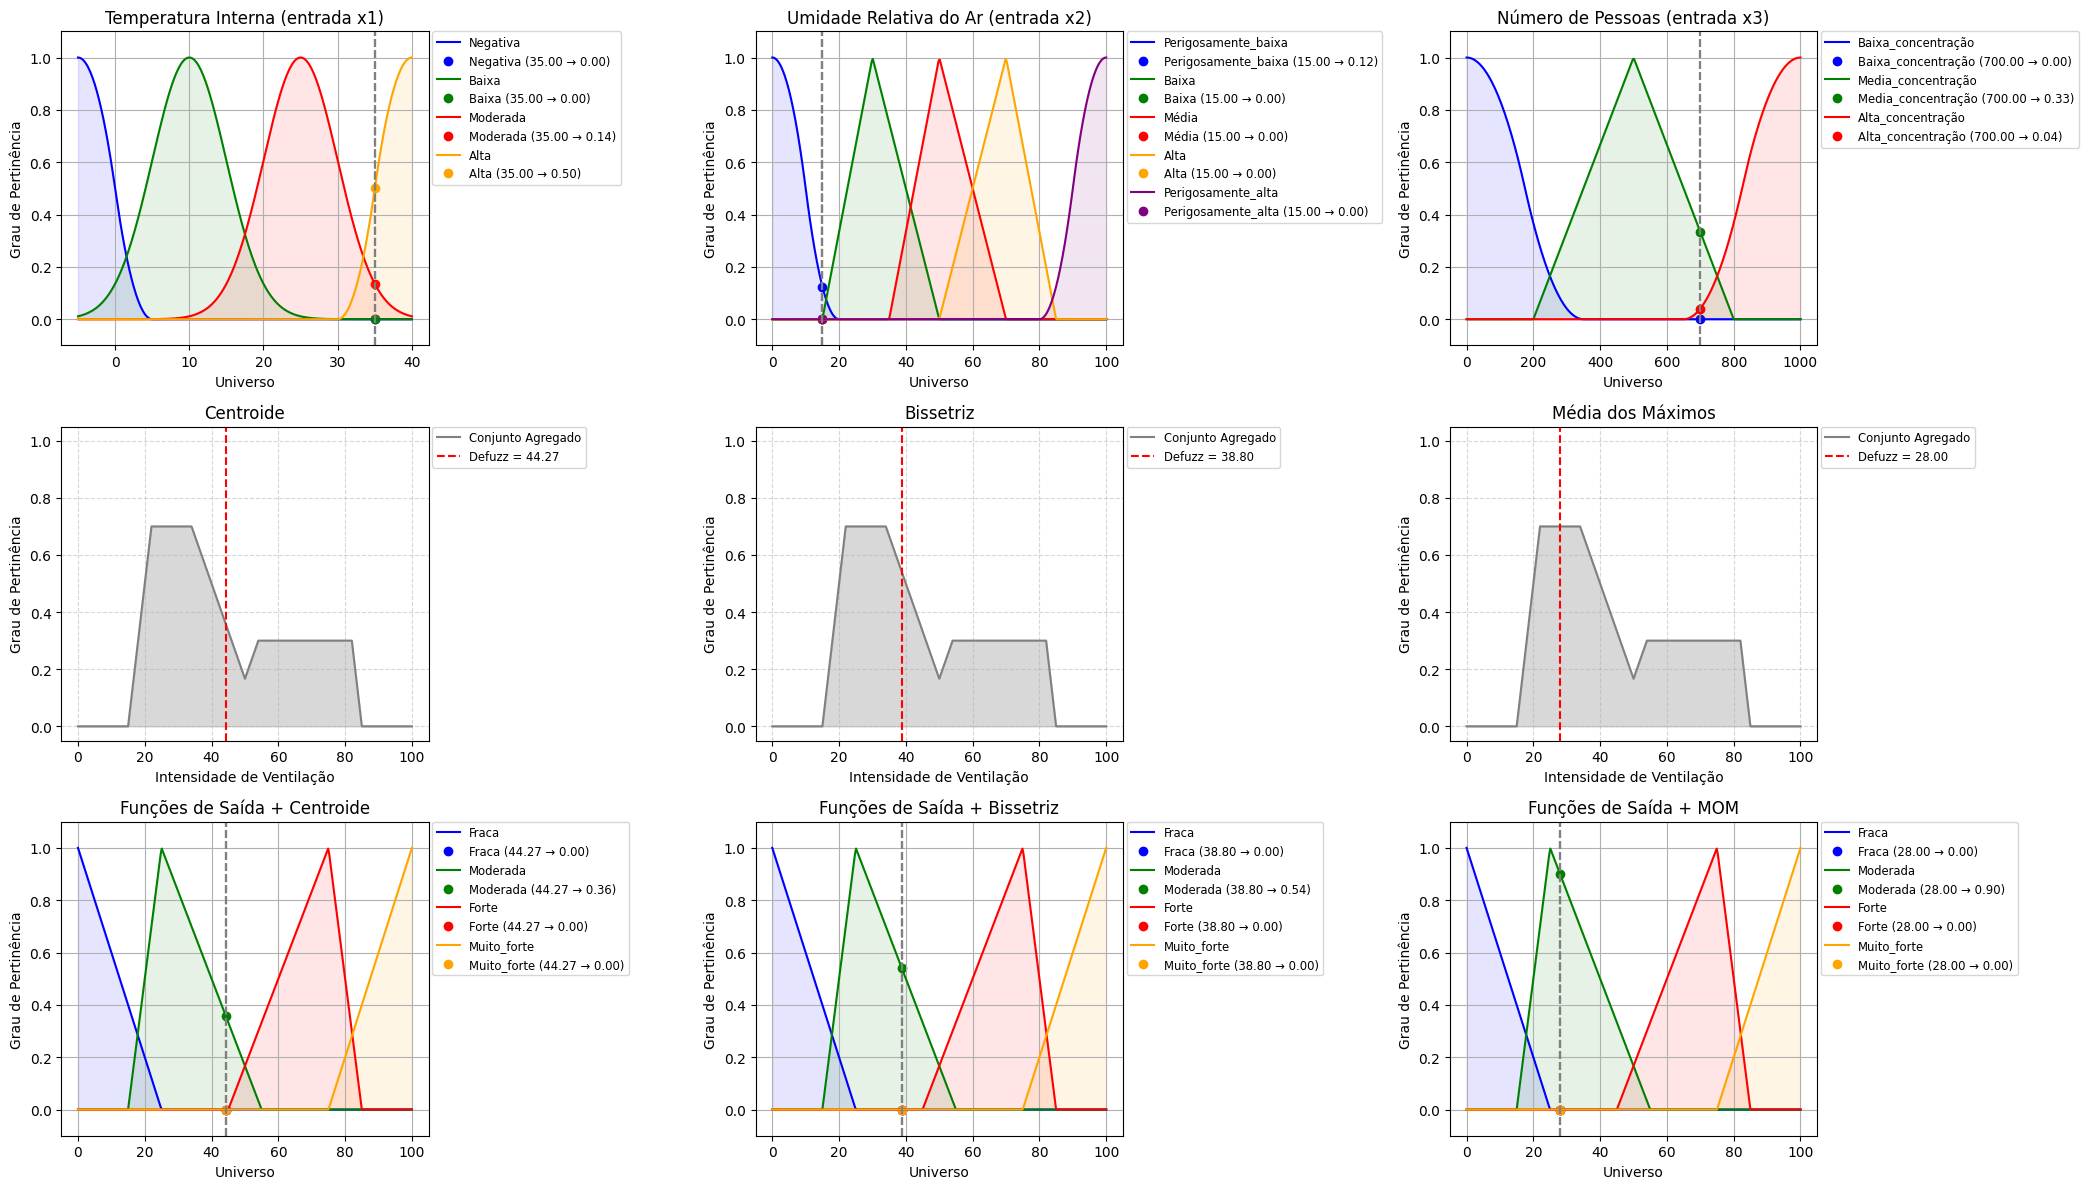

In [ ]:
# --- Plots --- (corrigido)
fig, axs = plt.subplots(3, 3, figsize=(21, 12))

# Entradas
plot_funcoes_geral(entrada_x1, entrada_x1_nomes, universo=(-5, 40), ponto=tp_interna_x1, ax=axs[0, 0])
axs[0, 0].set_title('Temperatura Interna (entrada x1)')

plot_funcoes_geral(entrada_x2, entrada_x2_nomes, universo=(0, 100), ponto=ur_x2, ax=axs[0, 1])
axs[0, 1].set_title('Umidade Relativa do Ar (entrada x2)')

plot_funcoes_geral(entrada_x3, entrada_x3_nomes, universo=(0, 1000), ponto=n_pessoas_x3, ax=axs[0, 2])
axs[0, 2].set_title('Número de Pessoas (entrada x3)')

# Conjunto Agregado + Defuzzificação
plot_conjunto_agregado(y, saida_agregada, centroide, ax=axs[1, 0])
axs[1, 0].set_title('Centroide')

plot_conjunto_agregado(y, saida_agregada, bissetriz, ax=axs[1, 1])
axs[1, 1].set_title('Bissetriz')

plot_conjunto_agregado(y, saida_agregada, mom, ax=axs[1, 2])
axs[1, 2].set_title('Média dos Máximos')

# Funções de saída com ponto marcado
plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=centroide, ax=axs[2, 0])
axs[2, 0].set_title('Funções de Saída + Centroide')

plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=bissetriz, ax=axs[2, 1])
axs[2, 1].set_title('Funções de Saída + Bissetriz')

plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=mom, ax=axs[2, 2])
axs[2, 2].set_title('Funções de Saída + MOM')

plt.tight_layout()
plt.show()

## Teste 4

In [ ]:


# -----------Variaveis de Entrada---------- #
tp_interna_x1 = 5
ur_x2 = 15
n_pessoas_x3 = 30



# --- Fuzzificação -------------------------#

graus_temp    = {nome: calcular_grau(tp_interna_x1, params)
                 for nome, params in zip(entrada_x1_nomes, entrada_x1)}

graus_umidade = {nome: calcular_grau(ur_x2, params)
                 for nome, params in zip(entrada_x2_nomes, entrada_x2)}

graus_pessoas = {nome: calcular_grau(n_pessoas_x3, params)
                 for nome, params in zip(entrada_x3_nomes, entrada_x3)}


# --- Inferência Mamdani --------------------
inferencia = {}
regras_ativadas = []

for id_regra, nome_temp, nome_umidade, nome_pessoas, saida in regras:

    grau_temp = graus_temp.get(nome_temp, 0)
    grau_umid = graus_umidade.get(nome_umidade, 0)
    grau_pessoas = graus_pessoas.get(nome_pessoas, 0)

    grau_inferencia = operador_logico(grau_temp, grau_umid, grau_pessoas, tipo='OR')  # AND, OR

    if grau_inferencia > 0:
       regras_ativadas.append((id_regra, nome_temp, nome_umidade, nome_pessoas, saida, grau_inferencia))

    inferencia[saida] = agregar_saida(inferencia.get(saida, 0), grau_inferencia, metodo='max')  # max, sum, mean, prod #


# --- Conjunção Mamdani --------------------]
for func_saida, label in zip(funcoes_de_saida, saída_y):
    grau = inferencia.get(label, 0)
    if grau > 0:
        # func_saida já é um lambda que mapeia x → pertinência
        corte = np.array([min(grau, func_saida(yi)) for yi in y])
        saida_agregada = np.maximum(saida_agregada, corte)


print("\nRegras Ativadas:")
if regras_ativadas:
    printar_regras_ativadas(regras_ativadas)
else:
    print("Nenhuma regra foi ativada.")

print("\n")

# Cálculo dos métodos de defuzzificação
centroide = defuzz_centroid(y, saida_agregada)
bissetriz = defuzz_bisector(y, saida_agregada)
mom       = defuzz_mom(y, saida_agregada)

print(f'Defuzzificações: \n')
print(f'Centroide: {centroide:.2f}')
print(f'Bissetriz: {bissetriz:.2f}')
print(f'Média dos Máximos (MOM): {mom:.2f}')
print("\n")


Regras Ativadas:
╒══════╤═══════════════╤═════════════════════╤════════════════════╤══════════╤════════════════════╕
│   ID │ Temperatura   │ Umidade             │ Pessoas            │ Saída    │   Grau de Ativação │
╞══════╪═══════════════╪═════════════════════╪════════════════════╪══════════╪════════════════════╡
│    1 │ Negativa      │ Perigosamente_baixa │ Baixa_concentração │ Fraca    │              0.985 │
├──────┼───────────────┼─────────────────────┼────────────────────┼──────────┼────────────────────┤
│    2 │ Negativa      │ Perigosamente_baixa │ Media_concentração │ Fraca    │              0.125 │
├──────┼───────────────┼─────────────────────┼────────────────────┼──────────┼────────────────────┤
│    3 │ Negativa      │ Perigosamente_baixa │ Alta_concentração  │ Fraca    │              0.125 │
├──────┼───────────────┼─────────────────────┼────────────────────┼──────────┼────────────────────┤
│    4 │ Negativa      │ Baixa               │ Baixa_concentração │ Fraca    │    

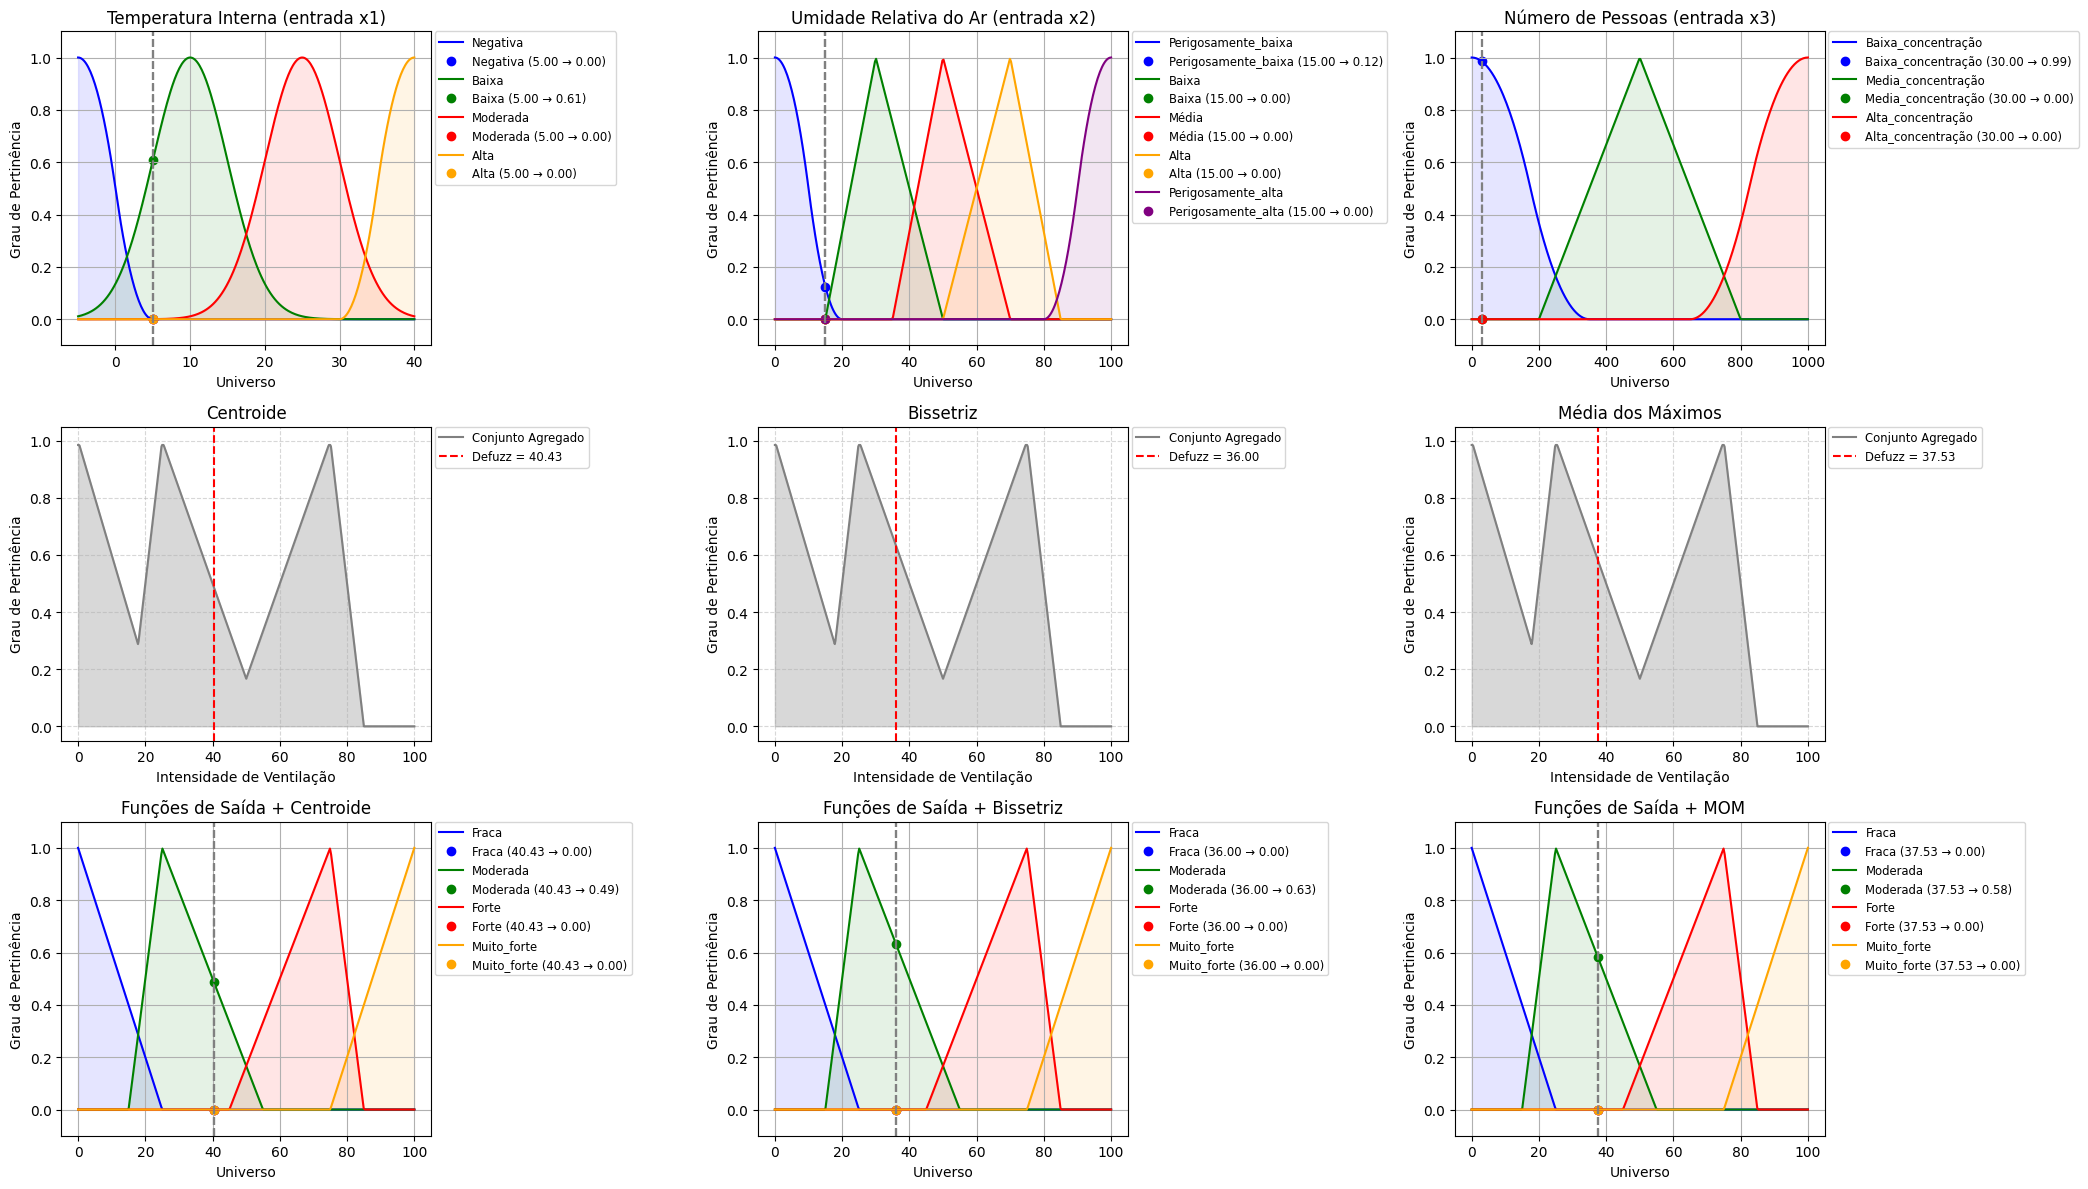

In [ ]:
# --- Plots --- (corrigido)
fig, axs = plt.subplots(3, 3, figsize=(21, 12))

# Entradas
plot_funcoes_geral(entrada_x1, entrada_x1_nomes, universo=(-5, 40), ponto=tp_interna_x1, ax=axs[0, 0])
axs[0, 0].set_title('Temperatura Interna (entrada x1)')

plot_funcoes_geral(entrada_x2, entrada_x2_nomes, universo=(0, 100), ponto=ur_x2, ax=axs[0, 1])
axs[0, 1].set_title('Umidade Relativa do Ar (entrada x2)')

plot_funcoes_geral(entrada_x3, entrada_x3_nomes, universo=(0, 1000), ponto=n_pessoas_x3, ax=axs[0, 2])
axs[0, 2].set_title('Número de Pessoas (entrada x3)')

# Conjunto Agregado + Defuzzificação
plot_conjunto_agregado(y, saida_agregada, centroide, ax=axs[1, 0])
axs[1, 0].set_title('Centroide')

plot_conjunto_agregado(y, saida_agregada, bissetriz, ax=axs[1, 1])
axs[1, 1].set_title('Bissetriz')

plot_conjunto_agregado(y, saida_agregada, mom, ax=axs[1, 2])
axs[1, 2].set_title('Média dos Máximos')

# Funções de saída com ponto marcado
plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=centroide, ax=axs[2, 0])
axs[2, 0].set_title('Funções de Saída + Centroide')

plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=bissetriz, ax=axs[2, 1])
axs[2, 1].set_title('Funções de Saída + Bissetriz')

plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=mom, ax=axs[2, 2])
axs[2, 2].set_title('Funções de Saída + MOM')

plt.tight_layout()
plt.show()

## Teste 5

In [ ]:
# -----------Variaveis de Entrada---------- #
tp_interna_x1 = -5
ur_x2 = 10
n_pessoas_x3 = 20



# --- Fuzzificação -------------------------#

graus_temp    = {nome: calcular_grau(tp_interna_x1, params)
                 for nome, params in zip(entrada_x1_nomes, entrada_x1)}

graus_umidade = {nome: calcular_grau(ur_x2, params)
                 for nome, params in zip(entrada_x2_nomes, entrada_x2)}

graus_pessoas = {nome: calcular_grau(n_pessoas_x3, params)
                 for nome, params in zip(entrada_x3_nomes, entrada_x3)}


# --- Inferência Mamdani --------------------
inferencia = {}
regras_ativadas = []

for id_regra, nome_temp, nome_umidade, nome_pessoas, saida in regras:

    grau_temp = graus_temp.get(nome_temp, 0)
    grau_umid = graus_umidade.get(nome_umidade, 0)
    grau_pessoas = graus_pessoas.get(nome_pessoas, 0)

    grau_inferencia = operador_logico(grau_temp, grau_umid, grau_pessoas, tipo='AND')  # AND, OR

    if grau_inferencia > 0:
       regras_ativadas.append((id_regra, nome_temp, nome_umidade, nome_pessoas, saida, grau_inferencia))

    inferencia[saida] = agregar_saida(inferencia.get(saida, 0), grau_inferencia, metodo='max')  # max, sum, mean, prod #


# --- Conjunção Mamdani --------------------]
for func_saida, label in zip(funcoes_de_saida, saída_y):
    grau = inferencia.get(label, 0)
    if grau > 0:
        # func_saida já é um lambda que mapeia x → pertinência
        corte = np.array([min(grau, func_saida(yi)) for yi in y])
        saida_agregada = np.maximum(saida_agregada, corte)


print("\nRegras Ativadas:")
if regras_ativadas:
    printar_regras_ativadas(regras_ativadas)
else:
    print("Nenhuma regra foi ativada.")

print("\n")

# Cálculo dos métodos de defuzzificação
centroide = defuzz_centroid(y, saida_agregada)
bissetriz = defuzz_bisector(y, saida_agregada)
mom       = defuzz_mom(y, saida_agregada)

print(f'Defuzzificações: \n')
print(f'Centroide: {centroide:.2f}')
print(f'Bissetriz: {bissetriz:.2f}')
print(f'Média dos Máximos (MOM): {mom:.2f}')
print("\n")


Regras Ativadas:
╒══════╤═══════════════╤═════════════════════╤════════════════════╤═════════╤════════════════════╕
│   ID │ Temperatura   │ Umidade             │ Pessoas            │ Saída   │   Grau de Ativação │
╞══════╪═══════════════╪═════════════════════╪════════════════════╪═════════╪════════════════════╡
│    1 │ Negativa      │ Perigosamente_baixa │ Baixa_concentração │ Fraca   │              0.500 │
├──────┼───────────────┼─────────────────────┼────────────────────┼─────────┼────────────────────┤
│   16 │ Baixa         │ Perigosamente_baixa │ Baixa_concentração │ Fraca   │              0.011 │
╘══════╧═══════════════╧═════════════════════╧════════════════════╧═════════╧════════════════════╛


Defuzzificações: 

Centroide: 40.43
Bissetriz: 36.00
Média dos Máximos (MOM): 37.53




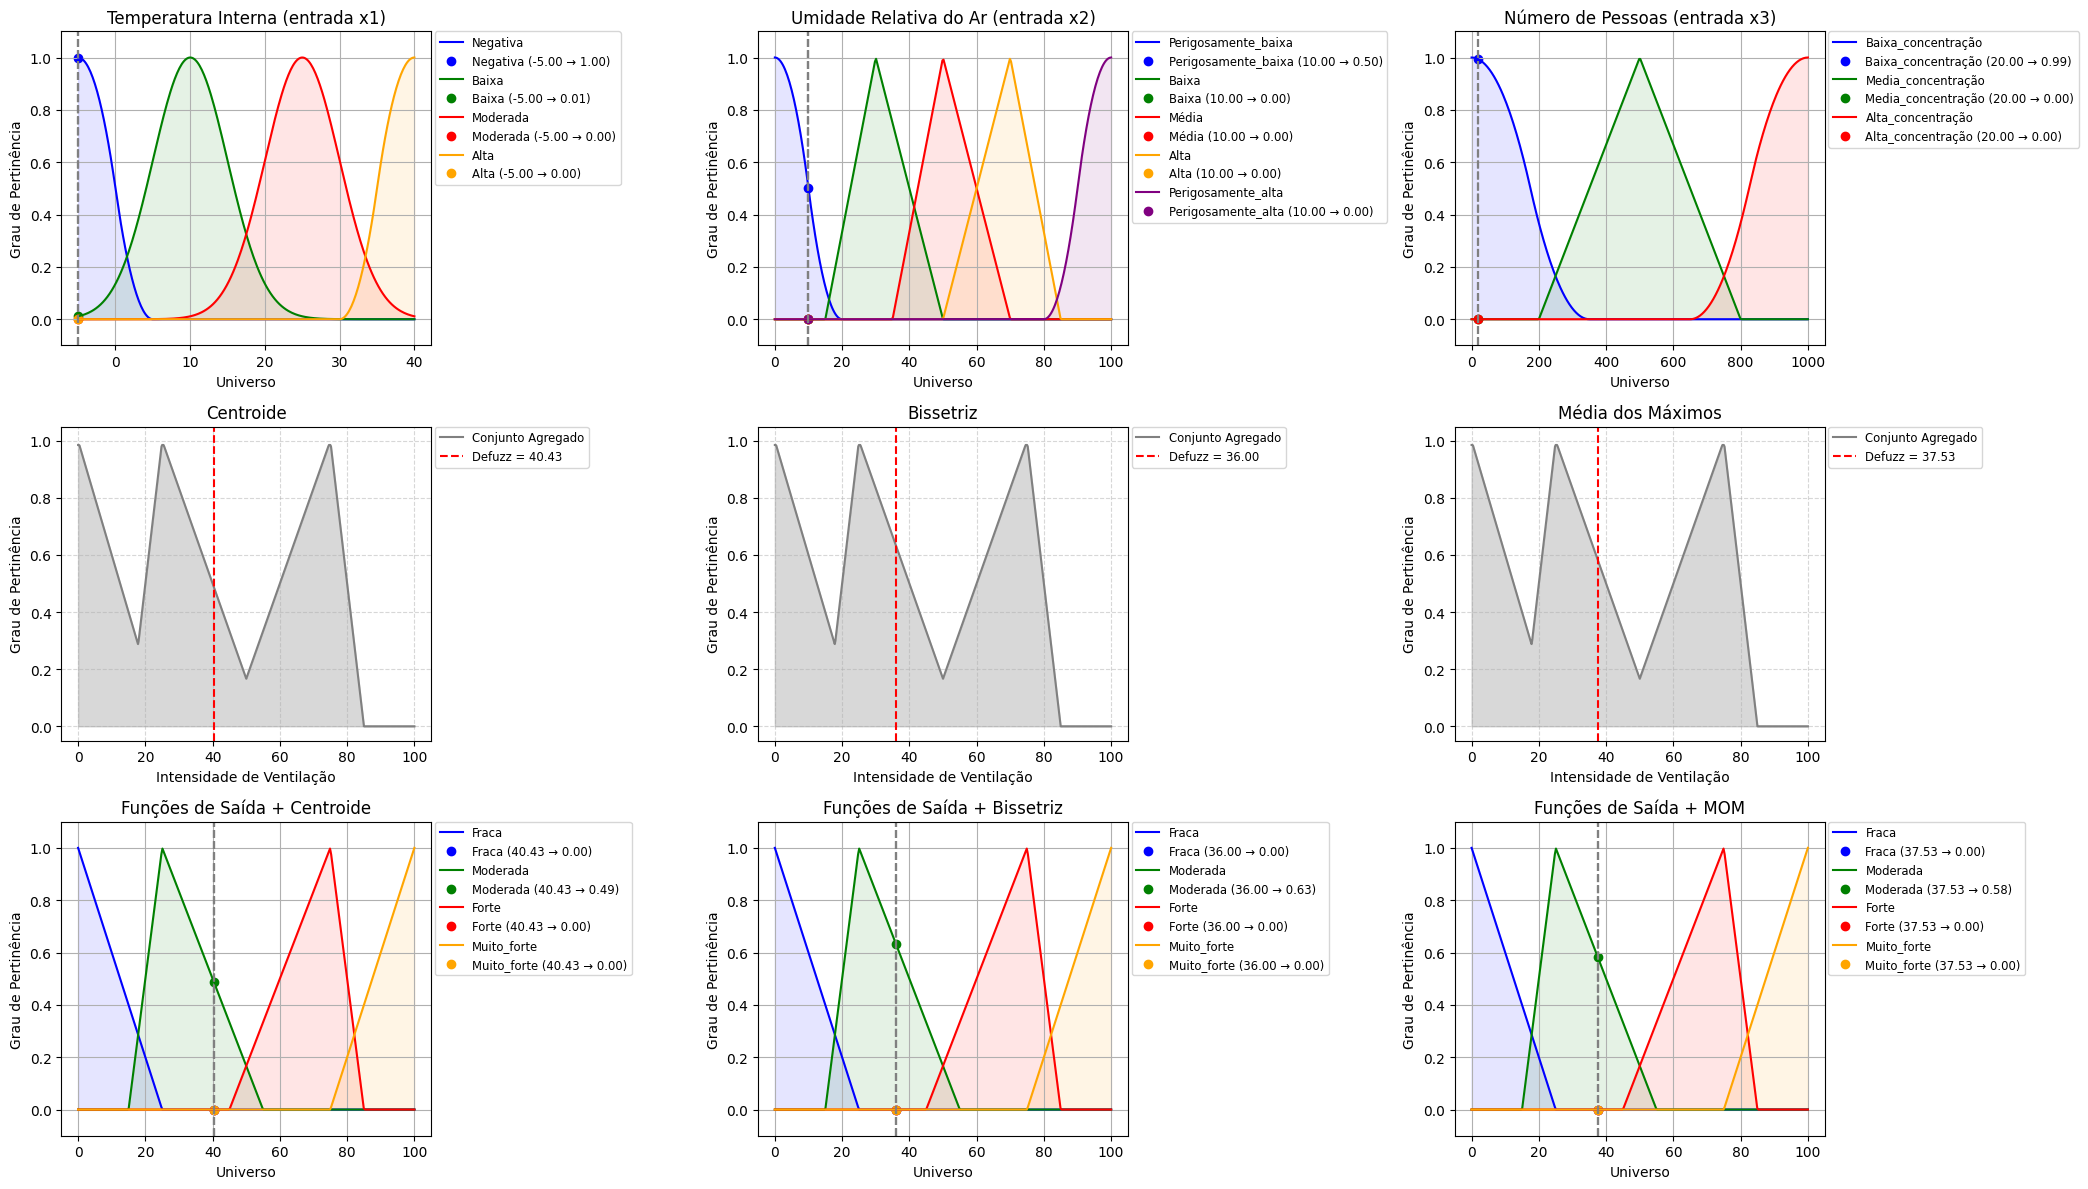

In [ ]:
# --- Plots ---
fig, axs = plt.subplots(3, 3, figsize=(21, 12))

# Entradas
plot_funcoes_geral(entrada_x1, entrada_x1_nomes, universo=(-5, 40), ponto=tp_interna_x1, ax=axs[0, 0])
axs[0, 0].set_title('Temperatura Interna (entrada x1)')

plot_funcoes_geral(entrada_x2, entrada_x2_nomes, universo=(0, 100), ponto=ur_x2, ax=axs[0, 1])
axs[0, 1].set_title('Umidade Relativa do Ar (entrada x2)')

plot_funcoes_geral(entrada_x3, entrada_x3_nomes, universo=(0, 1000), ponto=n_pessoas_x3, ax=axs[0, 2])
axs[0, 2].set_title('Número de Pessoas (entrada x3)')

# Conjunto Agregado + Defuzzificação
plot_conjunto_agregado(y, saida_agregada, centroide, ax=axs[1, 0])
axs[1, 0].set_title('Centroide')

plot_conjunto_agregado(y, saida_agregada, bissetriz, ax=axs[1, 1])
axs[1, 1].set_title('Bissetriz')

plot_conjunto_agregado(y, saida_agregada, mom, ax=axs[1, 2])
axs[1, 2].set_title('Média dos Máximos')

# Funções de saída com ponto marcado
plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=centroide, ax=axs[2, 0])
axs[2, 0].set_title('Funções de Saída + Centroide')

plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=bissetriz, ax=axs[2, 1])
axs[2, 1].set_title('Funções de Saída + Bissetriz')

plot_funcoes_geral(funcoes_de_saida, saída_y, universo=(0, 100), ponto=mom, ax=axs[2, 2])
axs[2, 2].set_title('Funções de Saída + MOM')

plt.tight_layout()
plt.show()